<h1 align="center">BDCC - Big Data Challenge</h1>

<h2 align="center">1M Sample from Dataset</h2>

<p style="text-align:center">
    António Almeida, up201505836<br>
    Miguel Ramalho,  up201403027<br>
    Tomás Albuquerque,  up201106437
</p>

This work is based on a dataset containing hospital events as described [here](https://mimic.physionet.org/mimictables/chartevents/), the provided dataset is _~4.2GB_ (compressed) and accounts for more than 330M instances. It is available [here](https://console.cloud.google.com/storage/browser/big_events/?prefix=EVENTS.csv.gz). For the initial development of this report, a sample with 1M datapoints (the first 1M) was isolated.

More data regarding the same context can be found [here](http://www.dcc.fc.up.pt/~ines/MIMIC-III/).

For this project we have used the `EVENTS`, `ADMISSIONS` and `CAREGIVERS` tables.

### Install required libraries

In [4]:
!pip3 install matplotlib dask gcsfs seaborn distributed dask_ml dask-xgboost

### Initial Imports

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns
sns.set()

In [8]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client()

### Utilities functions

In [9]:
# reads a DASK DataFrame from an EVENTS csv
def read_events(filename):
    return dd.read_csv(filename, parse_dates=['CHARTTIME', 'STORETIME'], dtype={'CGID': 'Int64','ICUSTAY_ID': 'Int64'})

# Data Visualization
This section contains some of the requested plots and some more high level information about the dataset and its contents

In [10]:
%matplotlib inline

In [11]:
path = './EVENTS_1000000.csv'
# path = 'gs://bdcc_up201505836/EVENTS.csv'
df = read_events(path)

In [12]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,15.00,15.00,L/min,0,0,NaN,NaN
1,789,36,165660,241249,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,100.00,100.00,NaN,0,0,NaN,NaN
2,790,36,165660,241249,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823,0.37,0.37,NaN,0,0,NaN,NaN
3,791,36,165660,241249,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,6.00,6.00,min,0,0,NaN,NaN
4,792,36,165660,241249,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,2.50,2.50,NaN,0,0,NaN,NaN


In [9]:
df.compute().describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CGID,VALUE,VALUENUM,WARNING,ERROR,RESULTSTATUS,STOPPED
count,9.999990e+05,999999.000000,999999.000000,999542.000000,999999.000000,847390.000000,999999.000000,999999.000000,999999.000000,999999.000000,0.0,0.0
mean,5.003201e+05,5800.489858,148498.552431,254446.497683,222180.309609,18182.896204,85.618958,85.618958,0.065634,0.001921,NaN,NaN
std,2.892129e+05,3503.306794,27689.259457,31045.418397,2488.229065,2288.817959,778.306520,778.306520,0.247641,0.043787,NaN,NaN
min,1.000000e+00,23.000000,100009.000000,200203.000000,220045.000000,14023.000000,-610.000000,-610.000000,0.000000,0.000000,NaN,NaN
25%,2.500005e+05,2636.000000,128932.000000,225777.000000,220180.000000,16037.000000,17.000000,17.000000,0.000000,0.000000,NaN,NaN
50%,5.000000e+05,5885.000000,142471.000000,256064.000000,220277.000000,18462.000000,56.000000,56.000000,0.000000,0.000000,NaN,NaN
75%,7.499995e+05,8799.000000,172420.000000,284784.000000,224684.000000,20652.000000,97.000000,97.000000,0.000000,0.000000,NaN,NaN
max,1.058971e+06,10694.000000,199622.000000,299972.000000,228377.000000,21545.000000,598185.120000,598185.120000,1.000000,1.000000,NaN,NaN


### Scatter Plot of values per item
- For a given item, i.e., `ITEMID`, get its respective rows
- Plot its items, i.e., `VALUENUM` entries
- A scatter plot was used as it represents more appropriately the data presented

In [13]:
def item_hist(df, item):
    df[['ITEMID', 'CHARTTIME', 'VALUENUM']]\
        .query(f'ITEMID == {item}')\
        .compute()\
        .plot(x='CHARTTIME', y='VALUENUM', style='.', figsize=(14,7), title=f'Values for ITEMID {item}')
    
    # display options
    ax = plt.gca(); ax.set_xlabel('Time'); ax.set_ylabel('Values')

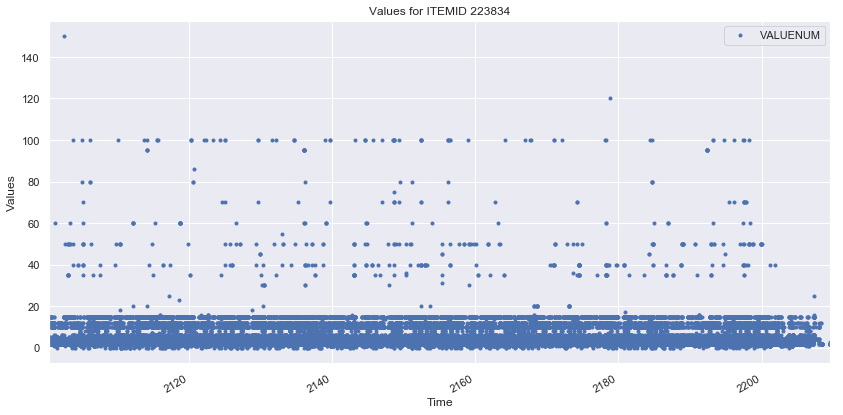

In [14]:
item_hist(df, item=223834)

### Histogram of values per patient

- For each patient, i.e., `SUBJECT_ID`, get its hospital admissions, i.e., `HADM_ID`
- For each hospital admission, plot the entries for each item, i.e., `VALUENUM` for each `ITEMID`
- A scatter plot was used as it represents more appropriately the data presented

In [15]:
# Get histogram of values per patient
def patient_hist(df, patient):
    df[['SUBJECT_ID', 'ITEMID', 'VALUENUM', 'HADM_ID']]\
                .query(f'SUBJECT_ID == {patient}')\
                .compute()\
                .groupby('HADM_ID')['ITEMID', 'VALUENUM']\
                .plot(x='ITEMID', y='VALUENUM', kind='scatter', figsize=(14,7), title="Values per patient", c="b")

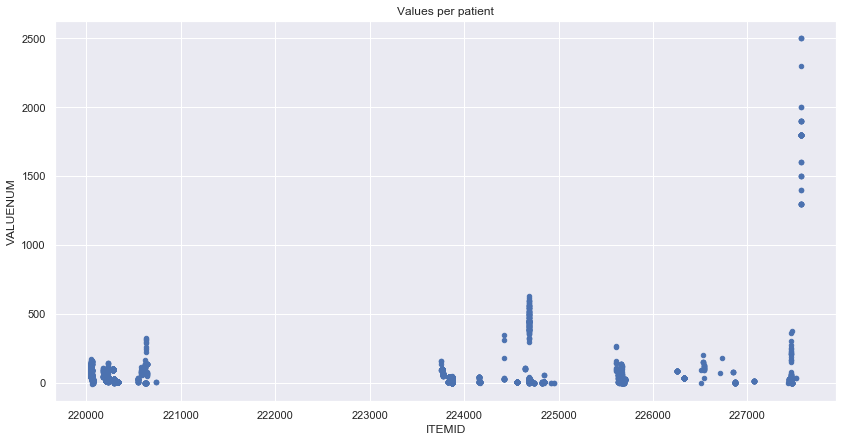

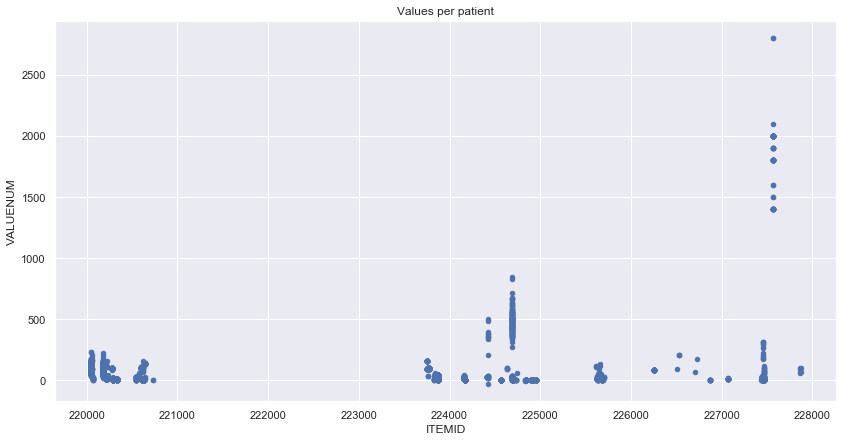

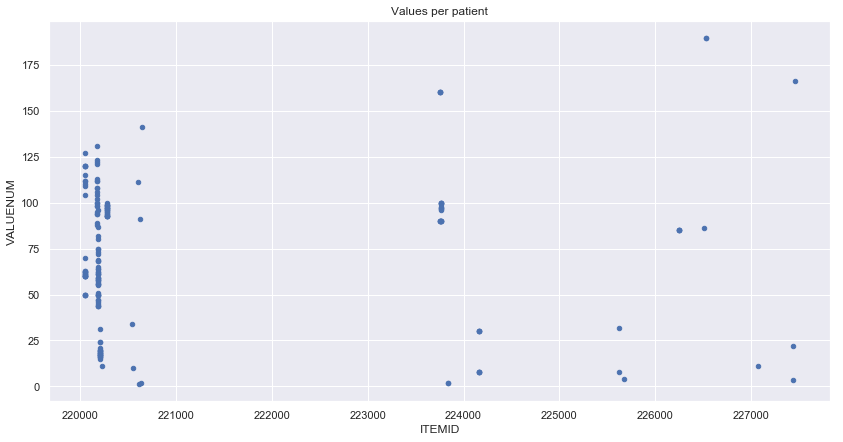

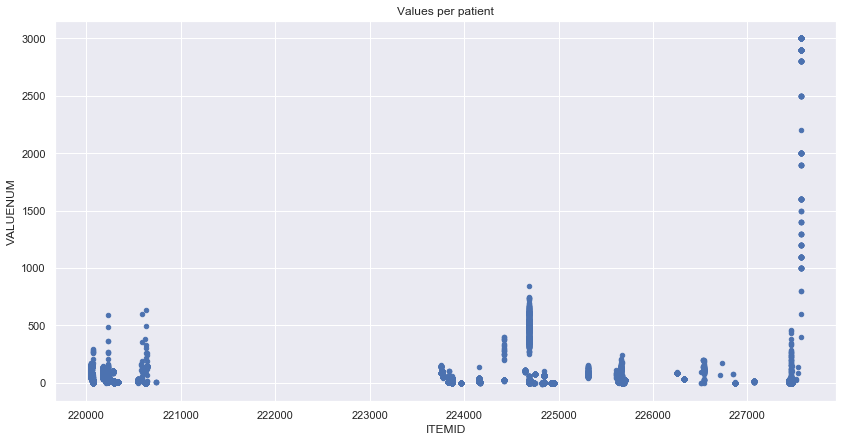

In [16]:
patient_hist(df, patient=2090)

### Histogram of frequency per item

In [17]:
# Get histogram of frequency per item
def item_hist(df):
    df[['ITEMID', 'VALUENUM']].compute().groupby('ITEMID').count().hist(figsize=(14, 7))
    
    # display options
    ax = plt.gca(); ax.set_xlabel('Items'); ax.set_ylabel('Frequency'); ax.set_title('Frequency per item')

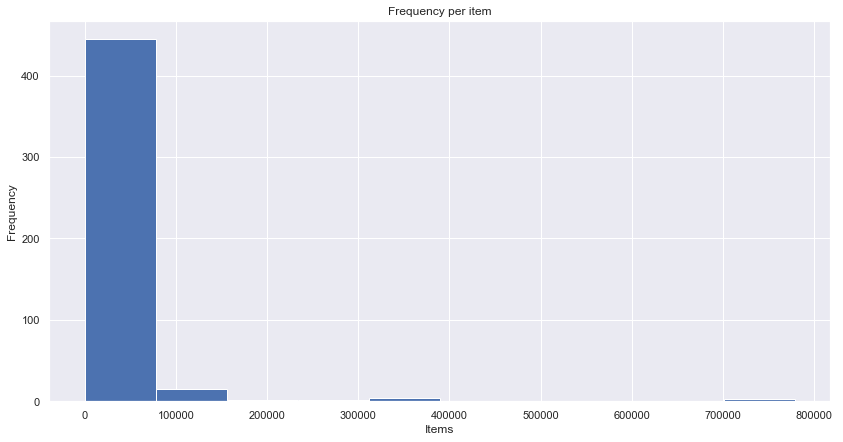

In [18]:
item_hist(df)

### Items's values over time for a given ICU
- For a given Intensive Care Unit instance, i.e., `ICUSTAY_ID`, get its entries
- Plot its items' values, i.e., `VALUENUM` entries, over time

In [19]:
def icu_hist(df, icu):
    df_icu = df[['SUBJECT_ID', 'VALUENUM', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID']]\
                .query(f'ICUSTAY_ID == {icu}')\
                .compute()    
    sns.relplot(x="CHARTTIME", y="VALUENUM", col="ICUSTAY_ID",
                # hue="ITEMID", #style="ITEMID", # size="VALUENUM",
                kind="line", legend="full",
                height=8, aspect=2, 
                data=df_icu);

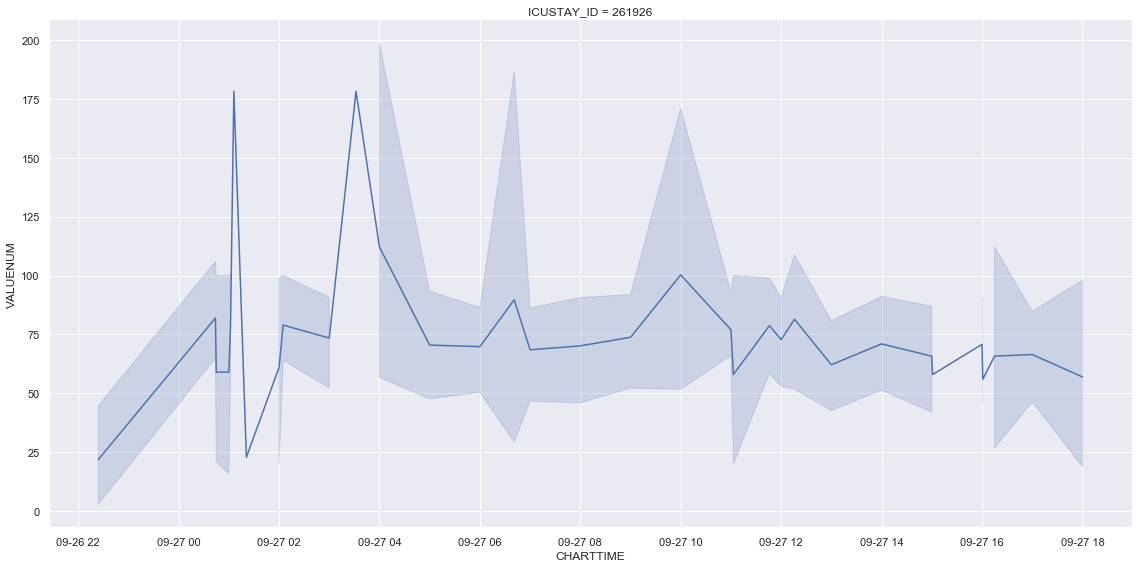

In [20]:
icu_hist(df, 261926)

# Simple Analysis of Admissions Table
This table will be used in the ML task, namely to get the Length of Stay (LoS) of a given patient, so a simple read and analysis is performed to extract some interesting insight.

_Note:_ The format used for the time information is not clear and yields strange dates, however, we are only focused on time differences so that is not a concern, since the absolute difference remains valid for the LoS calculation. 

In [21]:
# reads a DASK DataFrame from an ADMISSIONS csv
def read_admissions(filename="ADMISSIONS.csv"):
    return dd.read_csv(filename, parse_dates=['ADMITTIME', 'DISCHTIME', 'DEATHTIME'])

In [22]:
df_a = read_admissions()
df_a.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [23]:
df_a.describe().compute()

,ROW_ID,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,29488.500000,33755.583288,149970.809584,0.099261,0.973006
std,17025.049075,28092.726225,28883.095213,0.299014,0.162067
min,1.000000,2.000000,100001.000000,0.000000,0.000000
25%,14744.750000,11993.750000,124952.750000,0.000000,1.000000
50%,29488.500000,24133.500000,149989.500000,0.000000,1.000000
75%,44232.250000,53851.500000,174966.500000,0.000000,1.000000
max,58976.000000,99999.000000,199999.000000,1.000000,1.000000


In [24]:
deaths = len(df_a[df_a.DEATHTIME.notnull()])
adm = len(df_a)
print("Number of deaths: %d/%d (%.2f%% of the number of admissions)" % (deaths, adm, 100*deaths/adm))

Number of deaths: 5854/58976 (9.93% of the number of admissions)


Calculate the **LoS** for each admission

In [25]:
df_los = (df_a.DISCHTIME - df_a.ADMITTIME).dt.total_seconds().compute().to_frame()
df_los.columns = ["los"]
df_los["HADM_ID"] = df_a.HADM_ID
df_los["dead"] = df_a.DEATHTIME.notnull()
df_los["type"] = df_a.ADMISSION_TYPE
df_los["time"] = df_a.ADMITTIME

In [26]:
df_los.head()

,los,HADM_ID,dead,type,time
0,98880.0,165315,False,EMERGENCY,2196-04-09 12:26:00
1,474900.0,152223,False,ELECTIVE,2153-09-03 07:15:00
2,584760.0,124321,False,EMERGENCY,2157-10-18 19:34:00
3,246840.0,161859,False,EMERGENCY,2139-06-06 16:14:00
4,305340.0,129635,False,EMERGENCY,2160-11-02 02:06:00


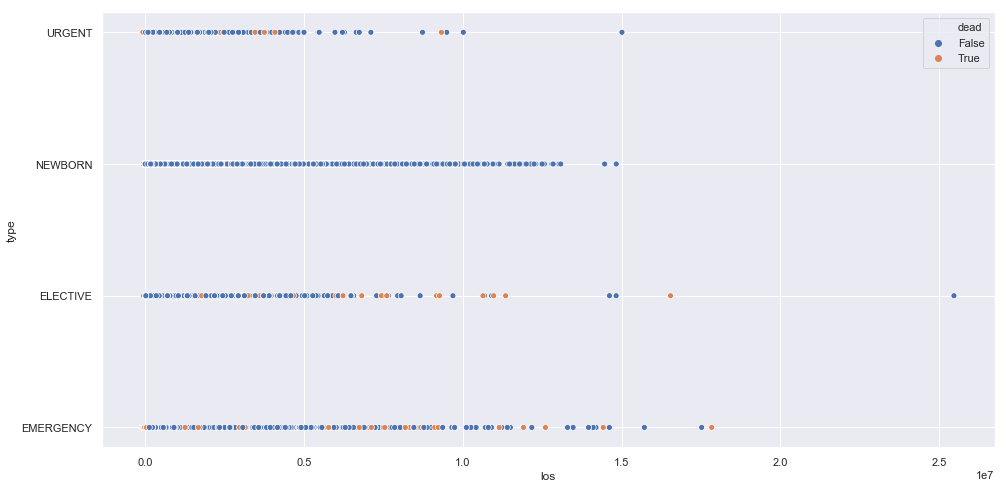

In [27]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="los", y="type", hue="dead", legend="full", data=df_los);

# Simple Analysis of Caregivers Table
This table will be used in the ML task, namely to get the total number of available caregivers. In a way, we will try to predict which caregivers are associated with longer stays. 

In [28]:
# reads a DASK DataFrame from an ADMISSIONS csv
def read_caregivers(filename="CAREGIVERS.csv"):
    return dd.read_csv(filename)

In [29]:
df_c = read_caregivers()
df_c.head()

,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory


What kind of caregivers are there?

In [30]:
print(df_c.DESCRIPTION.unique().compute().tolist())

['Read Only', 'Resident/Fellow/PA/NP', 'Respiratory', 'Rehabilitation', nan, 'Case Manager', 'RN', 'Attending', 'Social Worker', 'Pharmacist', 'Dietitian', 'PCT/NA', 'Administrator', 'Pastoral Care', 'Research Assistant', 'UCO', 'IMD']


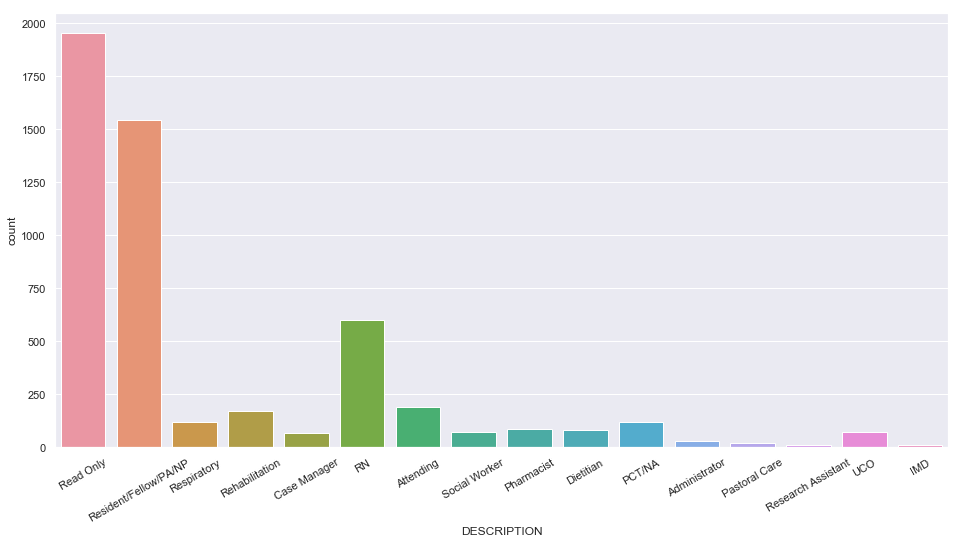

In [31]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x="DESCRIPTION", data=df_c.compute())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

# Machine Learning Task - Constructing the Dataset
The goal is to generate the clean dataset for the prediction task: `[FEATURES | Target]` where target is the LoS value (seconds)

In [32]:
ds = df_los[["HADM_ID", "los", "time"]]
ds.head()

,HADM_ID,los,time
0,165315,98880.0,2196-04-09 12:26:00
1,152223,474900.0,2153-09-03 07:15:00
2,124321,584760.0,2157-10-18 19:34:00
3,161859,246840.0,2139-06-06 16:14:00
4,129635,305340.0,2160-11-02 02:06:00


Get the number of events for each Hospital Admission

In [33]:
events = df.groupby("HADM_ID")["ROW_ID"].count().compute().to_frame().reset_index();
events.head()

,HADM_ID,ROW_ID
0,100009,846
1,100473,206
2,100765,1372
3,100795,8544
4,100889,191


Join the number of events to our current dataset

In [34]:
t1 = dd.merge(ds, events, on="HADM_ID")
t1.columns=["HADM_ID", "los", "time", "events"]
t1.head()

,HADM_ID,los,time,events
0,124321,584760.0,2157-10-18 19:34:00,320
1,144319,226620.0,2191-02-23 05:23:00,346
2,165660,870360.0,2134-05-10 11:30:00,1342
3,101651,278700.0,2199-10-20 12:05:00,248
4,117876,2380080.0,2199-12-21 22:37:00,4502


Get the subject id for each hospital admission (this is relevant as each patient can have more than one admission and we had no way of knowing that without this information)

In [35]:
subs = df.groupby("HADM_ID")["SUBJECT_ID"].first().compute().to_frame().reset_index()

In [36]:
t2 = dd.merge(t1, subs, on="HADM_ID")
t2 = t2[["HADM_ID", "SUBJECT_ID", "time", "events", "los"]]
t2.head()

,HADM_ID,SUBJECT_ID,time,events,los
0,124321,23,2157-10-18 19:34:00,320,584760.0
1,144319,34,2191-02-23 05:23:00,346,226620.0
2,165660,36,2134-05-10 11:30:00,1342,870360.0
3,101651,357,2199-10-20 12:05:00,248,278700.0
4,117876,357,2199-12-21 22:37:00,4502,2380080.0


Get a list of all the caregivers for each hospital admission and turn them into binary features

In [37]:
cg = df.groupby("HADM_ID")["CGID"].apply(set, meta=("Int64")).compute().to_frame().reset_index()
cg.columns = ["HADM_ID", "cgids"]
cg['cgids'] = cg['cgids'].astype(str)
cg.head()

,HADM_ID,cgids
0,100068,"{14913, 21025, 17473, 18787, 20070, 17130, 154..."
1,100250,"{15040, 17744, 18928, 15440, 20889, 15834}"
2,100265,"{17873, 16866, 19742, 20889}"
3,100269,{20889}
4,100391,"{18722, 17250, 16171, 19085, 16302, 19152, 208..."


In [38]:
features = cg["cgids"].str.replace(' ','').str.replace('{','').str.replace('}','').str.get_dummies(sep=',')
features.head()

,14010,14023,14033,14037,14045,14056,14084,14094,14103,14105,...,21473,21476,21478,21484,21488,21492,21499,21521,21545,nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
t3 = dd.merge(left=t2, right=features)
t3 = t3[[c for c in t3 if c not in ["nan", "los"]] + ["los"]]
t3.head()

,HADM_ID,SUBJECT_ID,time,events,14010,14023,14033,14037,14045,14056,...,21473,21476,21478,21484,21488,21492,21499,21521,21545,los
0,124321,23,2157-10-18 19:34:00,320,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,584760.0
1,144319,34,2191-02-23 05:23:00,346,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,226620.0
2,165660,36,2134-05-10 11:30:00,1342,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,870360.0
3,101651,357,2199-10-20 12:05:00,248,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,278700.0
4,117876,357,2199-12-21 22:37:00,4502,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2380080.0


Convert to new `dataset`variable and sort by ascending time

In [40]:
dataset = t3.sort_values("time")
dataset.head()

,HADM_ID,SUBJECT_ID,time,events,14010,14023,14033,14037,14045,14056,...,21473,21476,21478,21484,21488,21492,21499,21521,21545,los
4875,125380,31585,2100-07-02 19:28:00,243,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,427020.0
7247,120254,41552,2100-07-05 13:52:00,238,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,265980.0
5653,113129,42357,2100-07-14 02:04:00,365,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,390060.0
3721,136246,31288,2100-07-16 11:29:00,269,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,541860.0
3433,198779,31263,2100-07-18 23:51:00,1152,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,738180.0


Normalize the events to be in the `[0, 1]` range

In [41]:
from dask_ml.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset["events"] = scaler.fit_transform(dataset[["events"]])

In [43]:
dataset.head()

,HADM_ID,SUBJECT_ID,time,events,14010,14023,14033,14037,14045,14056,...,21473,21476,21478,21484,21488,21492,21499,21521,21545,los
4875,125380,31585,2100-07-02 19:28:00,0.000558,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,427020.0
7247,120254,41552,2100-07-05 13:52:00,0.000546,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,265980.0
5653,113129,42357,2100-07-14 02:04:00,0.000839,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,390060.0
3721,136246,31288,2100-07-16 11:29:00,0.000618,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,541860.0
3433,198779,31263,2100-07-18 23:51:00,0.002653,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,738180.0


Remove constant columns from the dataset, as not doing this will trigger an error in most regression algorithms we use bellow.

In [44]:
dataset = dataset.loc[:, (dataset != dataset.iloc[0]).any()]

In [45]:
del dataset["time"]

In [46]:
dataset.head(10)

,HADM_ID,SUBJECT_ID,events,14010,14023,14033,14037,14045,14056,14084,...,21473,21476,21478,21484,21488,21492,21499,21521,21545,los
4875,125380,31585,0.000558,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,427020.0
7247,120254,41552,0.000546,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,265980.0
5653,113129,42357,0.000839,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,390060.0
3721,136246,31288,0.000618,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,541860.0
3433,198779,31263,0.002653,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,738180.0
3677,174102,28239,0.000111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,446400.0
7379,116534,46467,0.002971,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,712200.0
5839,185717,44744,0.003241,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,607740.0
5546,101748,43782,0.001152,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,463320.0
5423,165465,41822,0.001385,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,387060.0


# Machine Learning Task
## Cross Validation + prediction + evaluation

**Note:** We tried using gradient boosted trees (`from dask_ml.xgboost import XGBRegressor`) but there seems to be an [unresolved bug](https://github.com/dask/dask-xgboost/issues/31) in this distributed implementation and, since the focus of this course is on distribution rather than ML techniques, we simplified and went for a simpler regressor.

Multiple regression techniques were tested, such as: LogisticRegression, LinearRegression, Ridge, Lasso, LassoLars, ElasticNet, ...

Since this is time data, we separate the past and train a model using cross validation and then we use that model to predict the future. This is done by separating the _timeline_ in two chunks, the train with 80% of the data and the predict with 20%. The dataset is an aggregation from the events dataframe according to the hospital admission and so it is sorted by admission time for that admission.

In [47]:
# from dask_ml.model_selection import KFold
# from dask_ml.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV 

In [48]:
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, LassoLars

Prepare the K-Fold cross-validation with 10 folds

In [49]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)

Separate 80-20, according to the time (data is sorted in ascending order, at this stage)

In [50]:
train_rows = int(0.8*len(dataset))
dataset_train = dataset.iloc[:train_rows, :]
dataset_predict = dataset.iloc[train_rows:, :]
print("train=", len(dataset_train))
print("predict=", len(dataset_predict))
print("total=", len(dataset))

train= 6896
predict= 1725
total= 8621


### 1º Simple features only
This part only uses the `SUBJECT_ID` and `events` as features

Separate the features (`X`) from the target variable (`y`)

In [51]:
# X = dataset.iloc[:, 1: len(dataset.columns) - 1].values
X = dataset_train.iloc[:, [2]].values
y = dataset_train.iloc[:, [-1]].values

In [52]:
# Predict
Xp = dataset_predict.iloc[:, [2]].values
yp = dataset_predict.iloc[:, [-1]].values

Train and score for each fold

In [53]:
scores = []
model = LinearRegression()
# model = LogisticRegression()
# model = Ridge(alpha=0.5)
# model = RidgeCV()
# model = Lasso(alpha=1)
# model = LassoLars(alpha=0.5)
# model = ElasticNet()
with joblib.parallel_backend('dask'):
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))

For this learning algorithm, we can get the [R^2 coefficient](https://en.wikipedia.org/wiki/Coefficient_of_determination) per fold ($\in [-1,1]$, where -1 is the worst, 0 is random estimator and 1 is perfect estimator)

In [54]:
print(scores)

[0.04929193100099117, 0.025499591044017778, -0.011560837270635504, 0.021443627133020504, 0.030774170696959424, 0.009297468564202993, 0.03030867198704323, -0.022759653809371283, 0.026412592221031986, 0.03441450616727204]


We can also get the coefficients for each feature

In [55]:
print(model.coef_[0])

[6555764.58956849]


Applying the model to the "unseen" data representing the future predictions we want to make

In [56]:
print("The predicted LoS in hours are: ", model.predict(Xp).T[0]//3600)

The predicted LoS in hours are:  [219. 219. 218. ... 220. 219. 225.]


In [57]:
print("The model score for the unseen data: %.4f" % model.score(Xp, yp))

The model score for the unseen data: 0.0230


### 2º Many binary features included
This part only uses, besides the `SUBJECT_ID` and `events` columns, all the previously defined binary features for the caregivers. The results are much worse, maybe due to the small amount of admissions and to the sparsity of these features, besides it can also be the case that the caregiver(s) in charge of patients are not important when the Length of Stay is considered.

Separate the features (`X`) from the target variable (`y`)

In [58]:
X = dataset_train.iloc[:, 1: len(dataset.columns) - 1].values
y = dataset_train.iloc[:, [-1]].values

In [59]:
# Predict
Xp = dataset_predict.iloc[:, 1: len(dataset.columns) - 1].values
yp = dataset_predict.iloc[:, [-1]].values

Train and score for each fold

In [60]:
scores = []
# model = LinearRegression()
# model = LogisticRegression()
model = Ridge(alpha=0.5)
# model = RidgeCV()
# model = Lasso(alpha=0.01)
# model = LassoLars(alpha=0.01)
# model = ElasticNet()
with joblib.parallel_backend('dask'):
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))

In [61]:
print(scores)

[-0.059677114852968005, -0.17110839251859658, -0.15151018968547114, -0.07234877454099342, -0.06492391821960486, -0.1141970012421687, -0.10983554960182729, -0.08687566456193108, -0.18721736599372152, -0.14063744489421537]


We can also get the coefficients for each feature

In [62]:
print("The first 10 coefficients are:\n", list(model.coef_[0])[:10])

The first 10 coefficients are:
 [0.6410281218499403, 5551173.302909249, -209705.70030602888, 51877.9401095341, 117019.86459509865, -336162.2743293109, -191644.7498022287, -106689.9275318691, -72545.97092858772, -209701.21727731422]


Applying the model to the "unseen" data representing the future predictions we want to make

In [63]:
print("The predicted LoS in hours are: ", model.predict(Xp).T[0]//3600)

The predicted LoS in hours are:  [206. 220. 192. ... 201. 362. 287.]


In [64]:
print("The model score for the unseen data: %.4f" % model.score(Xp, yp))

The model score for the unseen data: -0.1197


# Cloud Computing Remarks

After developing this notebook with distribution in mind, we applied it to the complete dataset. Several attempts to execute the presented notebook on the entire EVENTS dataset were made, with different methods, namely:

### Using [Google Compute Engine](https://cloud.google.com/compute/) 

Created multiple instances with different configurations, ranging from 8 to 24 vCPUs and up to 90GB of memory. Additional resources were not possible to be allocated, given the regions limits imposed by GCP. No instance proved viable enough to execute the notebook, mostly due to insufficient memory and overall unresponsiveness of the system. 

### Using [Google Kubernetes Engine](https://cloud.google.com/kubernetes-engine/)

Given the limitiations with GCE mentioned above, an attempt to setup a Dask instance on a Kubernetes cluster was made. The initial setup was successful and a cluster comprised of 4 nodes (each with 2vCPUs and 7.5GB of RAM). A [JupyterLab](https://github.com/jupyterlab/jupyterlab) instance was started to submit tasks to the scheduler, but running Dask related functions took a while, mostly because of untraceable errors messages and weak community support. We eventually got it to work and ran all the visualization and statistics sections of this notebook, on the entire dataset, only the Machine Learning task above was not executed in a feasible amount of time. The results can be found on the additionally provided notebook, `full.ipynb`.

All in all, we were able to execute most tasks but had to overcome the inherent challenges to using `dask` and `dask-ml`, which are relatively new technologies and still not very mature, albeit being very promising as only the ML task was not completed.

# Final Remarks about the Project
Overall, we were able to leverage Dask and Google Cloud Platform/Engine and Kubernetes Engine to analyze and visualize relevant information about the provided datasets (which were quite large). We also found that the features we selected for the prediction task did not yield very good results on the 1M sample, but since the goal of this project was process rather than results we decided to focus more on the first. As such, we have performed complex queries, such as: _filters, groupby, aggregations, joins, ..._ on a large amount of data, namely the full dataset (see [full.ipynb](full.ipynb)). 

As for the prediction task, we had the chance to use cross-validation and try out several algorithms. We also believe that, with further time investment in feature engineering, better results could be achieved for the prediction of length of stay, namely: isolate specific tests such as blood samples and drug administrations, as those typically reflect the gravity of the health condition that the patients have. We also took care to ensure that we split the data according to time so that we predict the future using the past and not the other way around, however the drawback of using cross-validation is that this happens for every fold except the last, but we used it anyway, as this was the required specifications. 

Finally, we learned a lot about the available tools for both reading, manipulating and visualizing large amounts of data. Further techniques, that were explored in previous practical assignments, could have been used (such as pipelines) but Dask proved to be a very good tool namely for lazy loading/computation and also by providing a higher level API for parallel processing in a cloud cluster. 

We consider ourselves better equipped to handle large amounts of data in the future :)